# Enhancing Text Classification in Information Retrieval: A Comprehensive Approach with TF-IDF, Naive Bayes, Word Embeddings, LSA, and SVM

In [1]:
import string
import time
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk import word_tokenize, PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from gensim.models import Word2Vec, FastText
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

## plot functions

In [2]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


## Preprocessors

In [3]:
def preprocess_text(text, remove_stopwords=True, stemming=True, lemmatization=True):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert to lower case
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english') + list(string.punctuation))
        tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    # Stemming
    if stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    # Lemmatization
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

## Inverted Index model

In [4]:


class InvertedIndex:
    """
    In this class, I implement an information retrieval system which can search a query among documents.
    ...
    Attributes:
    -----------
    collection_size: int
        number of documents.
    documents: List
        list of documents in format of Document object.
    posting_list: List[Token]
        list of Term objects. Terms store a string , document's indexes , cf and df
    stop_word: set
        set of stop words to check when tokenizing
    case_sensitive: bool
        a boolean to determine whether we want to distinguish between lowercase and uppercase form.
    tf_idf_matrix: List[List] (matrix)
        The tf-idf matrix that described in the slides.


    Methods
    -------
    Methods defined here:
        __init__(self, documents: List, case_sensitive=False):
            Constructor will set initial attributes like case_sensitivity. NOTE that documents should be read with read_document function after creating our IR system.
            :parameter
            ---------
            case_sensitive: bool
                boolean that determine whether the terms are case-sensetive. For more simplicity I set it to false, but It works when set to True too.(when we need to distinguish between a term in our query that has capital or small letter with other terms.)
            :return
                None

        get_token_index(self, x):
            this function find index of a word in posting list using binary search algorithm.
            :parameter
                x:str
                    the word you want to find its index
            :return
                int: index of the word in posting_list

        create_posting_list(self):
            calling this function, will create posting list of all occurred words cross all documents.
            :parameter
                None
            :return
                None

        create_tf_idf_matrix(self):
            This function will create a tf-idf matrix. I used the formula in the slides.
            :parameter
                None
            :return
                None
    """

    def __init__(self, dataset, case_sensitive=False):
        self.dataset = dataset
        self.posting_list = []
        self.positive_posting_list = []
        self.negative_posting_list = []

        self.tf_idf_matrix = []

    def get_term_index(self, posting_list, term):
        """
        This function find index of a word in posting list using binary search algorithm.
            :parameter
                x:str
                    the word you want to find its index
            :return
                int: index of the word in posting_list
        """
        low = idx = 0
        high = len(posting_list) - 1
        while low <= high:
            if high - low < 2:
                if posting_list[high]['word'] < term:
                    idx = high + 1
                    break
                elif posting_list[high]['word'] == term:
                    idx = high
                    break
                elif posting_list[low]['word'] >= term:
                    idx = low
                    break
            idx = (high + low) // 2
            if posting_list[idx]['word'] < term:
                low = idx + 1
            elif posting_list[idx]['word'] > term:
                high = idx - 1
            else:
                break
        return idx

    def create_posting_list(self, dataset):
        """
        calling this function, will create posting list of all occurred words cross all documents of the given dataset. in this function, I
        loop over all documents, then inside this loop, I loop over all the tokens that are in the current document.
        then I check if the length of posting_list is zero, then I add this token as first term. else if the length of
        posting_list is more than 0, I find the correct index of the token in posting_list alphabetically. then I check
        if this token, has been already in posting_list, I just add the current document index in tokens.docs, else, I
        add this token in the posting_list, then add the current document index. I also calculate cf and df during the loops.
            :parameter
                dataset
            :return
                The posting list of the given dataset
        :return:
        """
        posting_list = []
        for doc_id, doc in dataset.iterrows():
            doc_text = doc['text']
            tokenized_text = word_tokenize(doc_text)
            for token_idx, token in enumerate(tokenized_text):
                if len(posting_list) == 0:
                    posting_list.append({'word': token,
                                         'docs': [],
                                         'df': 0,
                                         'cf': 0,
                                         })
                    posting_list[0]['docs'].append({doc_id: [token_idx]})
                    posting_list[0]['cf'] += 1
                    continue

                idx = self.get_term_index(posting_list, token)

                if idx == len(posting_list):
                    posting_list.append({'word': token,
                                         'docs': [],
                                         'df': 0,
                                         'cf': 0,
                                         })
                    # self.posting_list[i].post_idx.append(post_idx)
                elif token != posting_list[idx]['word']:
                    posting_list.insert(idx, {'word': token,
                                              'docs': [],
                                              'df': 0,
                                              'cf': 0,
                                              })

                if len(posting_list[idx]['docs']) == 0:
                    posting_list[idx]['docs'].append({doc_id: [token_idx]})
                    posting_list[idx]['df'] += 1
                elif doc_id not in posting_list[idx]['docs'][-1].keys():
                    posting_list[idx]['docs'].append({doc_id: [token_idx]})
                    posting_list[idx]['df'] += 1
                else:
                    posting_list[idx]['docs'][-1][doc_id].append(token_idx)
                posting_list[idx]['cf'] += 1
        return posting_list

    def idf(self, df_t):
        return np.log(self.dataset.shape[0] / df_t)

    def create_tf_idf_matrix(self, dataset, use_sklearn=True):
        """
        This function will create a tf-idf matrix. I used the formula in the slides. Fisrt I set all values of the matrix to zeros then I loop over all terms in posting list and then loop over all documents in each term, an set the row of t-th term and doc_idx-th column to tf*idf.
        :return:
            None
        """
        if use_sklearn:
            vectorizer = TfidfVectorizer()
            X = vectorizer.fit_transform(dataset)
            return X
        else:
            collection_size = self.dataset.shape[0]
            tf_idf_matrix = np.zeros([len(self.posting_list), len(self.dataset)])
            print(tf_idf_matrix.shape)
            for t in range(len(self.posting_list)):
                for doc in self.posting_list[t]['docs']:
                    doc_idx, indexes = next(iter(doc.items()))
                    tf_idf_matrix[t, doc_idx] = len(doc[doc_idx]) * np.log(
                        collection_size / self.posting_list[t]['df'])

            for col_idx in range(len(self.dataset)):
                v_norm = np.linalg.norm(tf_idf_matrix[:, col_idx])
                if v_norm != 0:
                    tf_idf_matrix[:, col_idx] = tf_idf_matrix[:, col_idx] / v_norm
            return tf_idf_matrix



## Naive Bayes Classifier

In [5]:
class BaseClassifier:
    def __init__(self, indexing_model):
        self.indexing_model: InvertedIndex = indexing_model

    def train(self, **kwargs):
        raise NotImplementedError("Subclasses must override this method.")


class NaiveBayesClassifier(BaseClassifier):
    def __init__(self, indexing_model):
        super().__init__(indexing_model)
        self.prob_list = {
            'positive': {},
            'negative': {}
        }

    def train(self):
        """
        This function creates a table of probabilities using the formula from lecture 12.
        """
        # Compute B based on the slides:
        B = len(self.indexing_model.posting_list)  # Size of the vocabulary
        positive_word_size = B
        negative_word_size = B
        # Compute the Denominator of the positive class :
        for t in self.indexing_model.positive_posting_list:
            positive_word_size += t['cf']
        # Compute the Denominator of the negative class :
        for t in self.indexing_model.negative_posting_list:
            negative_word_size += t['cf']
        # Apply the formula in lecture 12. here we use logarithm to avoid roundoff
        for t in self.indexing_model.positive_posting_list:
            self.prob_list['positive'][t['word']] = np.log((t['cf'] + 1) / positive_word_size)
        for t in self.indexing_model.negative_posting_list:
            self.prob_list['negative'][t['word']] = np.log((t['cf'] + 1) / negative_word_size)

        self.positive_word_size = positive_word_size
        self.negative_word_size = negative_word_size
        return self

    def classify(self, document):
        """
        In this function I implement the naive bayes classifier. Because we apply logarithm to the probablities that we store in prob_list, we can use summotion for naive bayes.
        :param query: str
            the document we want to classify
        :return:
            return the predicted class of the document
        """
        tokenized_query = word_tokenize(document)
        neg_prob = 0
        pos_prob = 0
        for token in tokenized_query:
            try:
                neg_prob += self.prob_list['negative'][token]
            except:
                neg_prob += np.log(1 / self.positive_word_size)
            try:
                pos_prob += self.prob_list['positive'][token]
            except:
                pos_prob += np.log(1 / self.negative_word_size)
        return "positive" if pos_prob > neg_prob else "negative"

    def predict(self, X):
        y_pred = []
        for i in range(len(X)):
            y_pred.append(self.classify(X[i]))
        return y_pred


## Embedding functions

In [6]:
def document_embedding(doc, word_vectors):
    """
    Calculate the document embedding by averaging word vectors present in the document.

    Parameters:
    - doc (list of str): Tokenized words in the document.
    - word_vectors (gensim.models.keyedvectors.KeyedVectors): Word vectors for the vocabulary.

    Returns:
    - numpy.ndarray: Document embedding as a numpy array.
    """
    words = [word for word in doc if word in word_vectors]
    if not words:
        return np.zeros(word_vectors.vector_size)
    return np.mean(word_vectors[words], axis=0)


def create_word_embeddings(X, word_vectors):
    """
    Create document embeddings for a given dataset using the provided word vectors.

    Parameters:
    - X (list of list of str): Tokenized documents in the dataset.
    - word_vectors (gensim.models.keyedvectors.KeyedVectors): Word vectors for the vocabulary.

    Returns:
    - list of numpy.ndarray: List of document embeddings.
    """
    return [document_embedding(doc, word_vectors) for doc in X]


def apply_lsa(X_train, X_test, n_components=100):
    """
    Apply Latent Semantic Analysis (LSA) to the document embeddings.

    Parameters:
    - X_train (list of numpy.ndarray): Document embeddings of the training set.
    - X_test (list of numpy.ndarray): Document embeddings of the test set.
    - n_components (int): Number of components to keep in the truncated SVD.

    Returns:
    - tuple: Tuple containing the transformed training and test sets after applying LSA.
    """
    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    X_train_lsa = lsa.fit_transform(X_train)
    X_test_lsa = lsa.transform(X_test)
    return X_train_lsa, X_test_lsa



## Evaluations

In [7]:
def evaluation(y_true, y_pred, pos_label='positive'):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=pos_label)
    recall = recall_score(y_true, y_pred, pos_label=pos_label)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return {"Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "confusion-matrix": conf_matrix}


# 1-Document Preprocessing
I use the transformed-to-dataframe of the dataset.

### Concatenate the dataframe
 Since the dataframe has rating column, we can concatenate the positive and negative documents for more readablity and simplicity.

In [8]:
df_pos = pd.read_csv('../dataset/preprocessed/train_pos.csv')
df_neg = pd.read_csv('../dataset/preprocessed/train_neg.csv')
df_pos.sort_values(by=['ID'], inplace=True)
df_neg.sort_values(by=['ID'], inplace=True)
df_train = pd.concat([df_pos, df_neg], ignore_index=True)
df_train.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
df_train

,text,rating
0,Bromwell High is a cartoon comedy. It ran at t...,9
1,"If you like adult comedy cartoons, like South ...",7
2,Bromwell High is nothing short of brilliant. E...,9
3,"""All the world's a stage and its people actors...",10
4,FUTZ is the only show preserved from the exper...,8
...,...,...
24995,"OK, I love bad horror. I especially love horro...",1
24996,To be brutally honest... I LOVED watching Seve...,1
24997,I'm sure that the folks on the Texas/Louisiana...,4
24998,This film has the kernel of a really good stor...,2


In [9]:
df_pos_test = pd.read_csv('../dataset/preprocessed/test_pos.csv')
df_neg_test = pd.read_csv('../dataset/preprocessed/test_neg.csv')
df_pos_test.sort_values(by=['ID'], inplace=True)
df_neg_test.sort_values(by=['ID'], inplace=True)
df_test = pd.concat([df_pos_test, df_neg_test], ignore_index=True)
df_test.drop(columns=['Unnamed: 0', 'ID'], inplace=True)
df_test

,text,rating
0,I went and saw this movie last night after bei...,10
1,My boyfriend and I went to watch The Guardian....,10
2,My yardstick for measuring a movie's watch-abi...,7
3,How many movies are there that you can think o...,7
4,This movie was sadly under-promoted but proved...,10
...,...,...
24995,CyberTracker is set in Los Angeles sometime in...,3
24996,Eric Phillips (Don Wilson) is a secret service...,3
24997,Plot Synopsis: Los Angeles in the future. Crim...,4
24998,"Oh, dear! This has to be one of the worst film...",1


### Apply the preprocessor

In [10]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [11]:
X_train = df_train['text'].to_list()
y_train = ["positive" if i>5 else "negative"  for i in df_train['rating'].to_list()]
X_test = df_test['text'].to_list()
y_test = ["positive" if i>5 else "negative"  for i in df_test['rating'].to_list()]

# 2- Naive Bayes

### Build our system
Here we build our system. First we create an object of InvertedIndex with the train dataset. Then, I create 3 posting list:
- 1)The posting list of all documents.
- 2)The posting list of positive documents.
- 3)The posting list of negative documents.

In [12]:
inverted_index = InvertedIndex(dataset=df_train)

In [13]:
inverted_index.posting_list = inverted_index.create_posting_list(inverted_index.dataset)
inverted_index.positive_posting_list = inverted_index.create_posting_list(inverted_index.dataset[inverted_index.dataset['rating']>5])
inverted_index.negative_posting_list = inverted_index.create_posting_list(inverted_index.dataset[inverted_index.dataset['rating']<=5])

Let's take a look at our posting lists:

In [14]:
inverted_index.positive_posting_list[-10:]

[{'word': 'åge', 'docs': [{8712: [184]}], 'df': 1, 'cf': 1},
 {'word': 'æsthetic', 'docs': [{1830: [293]}], 'df': 1, 'cf': 1},
 {'word': 'écran', 'docs': [{11616: [51]}], 'df': 1, 'cf': 1},
 {'word': 'élan', 'docs': [{1078: [260]}, {1904: [90]}], 'df': 2, 'cf': 2},
 {'word': 'émigré',
  'docs': [{3533: [98]},
   {5598: [92]},
   {6907: [55]},
   {7243: [2]},
   {7781: [67]}],
  'df': 5,
  'cf': 5},
 {'word': 'était', 'docs': [{9940: [40, 50]}], 'df': 1, 'cf': 2},
 {'word': 'étc', 'docs': [{3511: [10]}], 'df': 1, 'cf': 1},
 {'word': 'êxtase', 'docs': [{5586: [164]}], 'df': 1, 'cf': 1},
 {'word': 'ís', 'docs': [{6438: [31]}], 'df': 1, 'cf': 1},
 {'word': 'østbye', 'docs': [{8712: [323]}], 'df': 1, 'cf': 1}]

In [15]:
inverted_index.negative_posting_list[-10:]

[{'word': 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
  'docs': [{22240: [80]}],
  'df': 1,
  'cf': 1},
 {'word': 'à',
  'docs': [{14601: [30]}, {21350: [37]}, {23380: [16]}],
  'df': 3,
  'cf': 3},
 {'word': 'ánd', 'docs': [{18696: [98]}], 'df': 1, 'cf': 1},
 {'word': 'åmål', 'docs': [{19523: [46]}], 'df': 1, 'cf': 1},
 {'word': 'émigré', 'docs': [{22356: [11]}], 'df': 1, 'cf': 1},
 {'word': 'éveri', 'docs': [{15920: [46]}], 'df': 1, 'cf': 1},
 {'word': 'ísnt', 'docs': [{24228: [37]}], 'df': 1, 'cf': 1},
 {'word': 'ø', 'docs': [{18782: [245]}], 'df': 1, 'cf': 1},
 {'word': 'über', 'docs': [{24406: [3]}, {24704: [285]}], 'df': 2, 'cf': 2},
 {'word': 'üvegtigri', 'docs': [{18627: [8]}], 'df': 1, 'cf': 1}]

## Now we want to apply naive bayes on our dataset.
The function we use here creates a table of probablity using the formula from lectur 12:
$\hat{P}(t|c) = \frac{T_{ct}+1}{\Sigma_{t'\in V}(T_{ct'} + 1)} = \frac{T_{ct} + 1}{(\Sigma_{t'\in V}T_{ct'})+B}$
where $B$ is the number of bins – in this case the number of different words or the
size of the vocabulary $|V | = M$

In [16]:
naive_bayes_model = NaiveBayesClassifier(indexing_model=inverted_index)
naive_bayes_model.train()

### Evaluation
Now we can apply our naive_bayes_classifier on test dataset:

In [17]:
evaluation_results = dict()

#### a) Evaluation on train set:

In [18]:
y_pred = naive_bayes_model.predict(X_train)
evaluation_results['naive-bayes-train'] = evaluation(y_train, y_pred)
print(evaluation_results['naive-bayes-train'])

{'Accuracy': 0.89748, 'Precision': 0.9184704792386086, 'Recall': 0.8724, 'F1-score': 0.8948426537562056, 'confusion-matrix': array([[11532,   968],
       [ 1595, 10905]])}


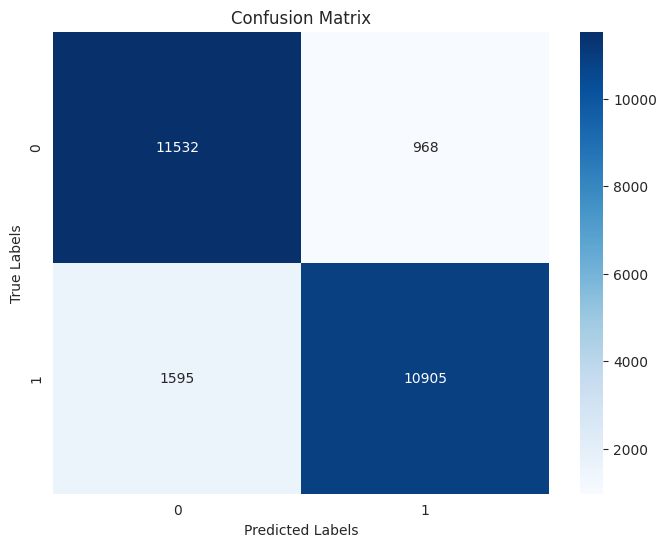

In [19]:
plot_confusion_matrix(cm=evaluation_results['naive-bayes-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [20]:
y_pred = naive_bayes_model.predict(X_test)
evaluation_results['naive-bayes-test']= evaluation(y_test, y_pred)
print(evaluation_results['naive-bayes-test'])

{'Accuracy': 0.81844, 'Precision': 0.8581841087015207, 'Recall': 0.76296, 'F1-score': 0.8077753779697624, 'confusion-matrix': array([[10924,  1576],
       [ 2963,  9537]])}


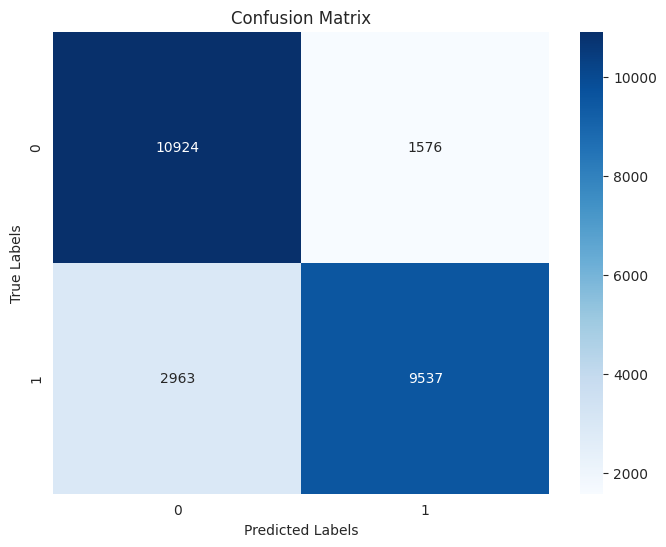

In [21]:
plot_confusion_matrix(cm=evaluation_results['naive-bayes-test']["confusion-matrix"])

#### As we can see, the evaluation of the model is actually very good!

# 3&4. Word Embeddings with SVM Classification and LSA with SVM Classification:

## a) Using tf-idf matrix:
We first create tf-idf matrix, and then use svm to classification. Then we will go to the next step and use other word embeddings

Let's first create a runtime list to compare the required time for training with and without lsa

In [22]:
runtime=dict()

In [23]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [24]:
start = time.time()

tfidf_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
tfidf_svm_clf.fit(X_train_tfidf, y_train)

end = time.time()
runtime['tf-idf'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [25]:
y_pred = tfidf_svm_clf.predict(X_train_tfidf)
evaluation_results['tf-idf-train'] = evaluation(y_train, y_pred)
print(evaluation_results['tf-idf-train'])

{'Accuracy': 0.95324, 'Precision': 0.9493931942571587, 'Recall': 0.95752, 'F1-score': 0.9534392798821046, 'confusion-matrix': array([[11862,   638],
       [  531, 11969]])}


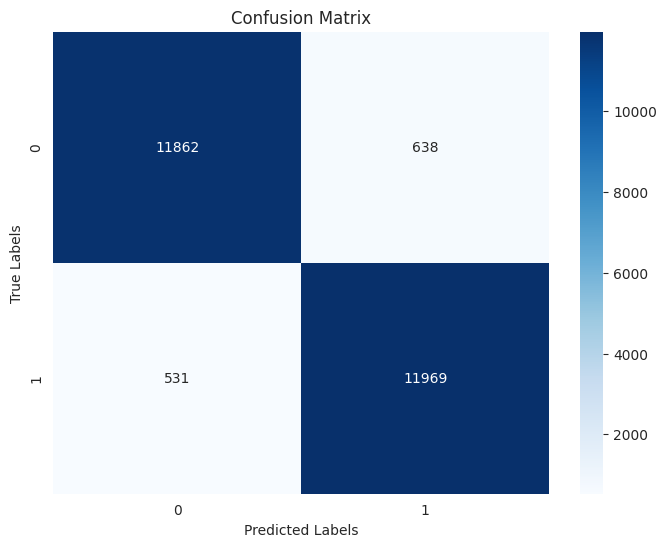

In [26]:
plot_confusion_matrix(cm=evaluation_results['tf-idf-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [27]:
y_pred = tfidf_svm_clf.predict(X_test_tfidf)
evaluation_results['tf-idf-test'] = evaluation(y_test, y_pred)
print(evaluation_results['tf-idf-test'])

{'Accuracy': 0.87036, 'Precision': 0.8785054370043333, 'Recall': 0.8596, 'F1-score': 0.8689499009340503, 'confusion-matrix': array([[11014,  1486],
       [ 1755, 10745]])}


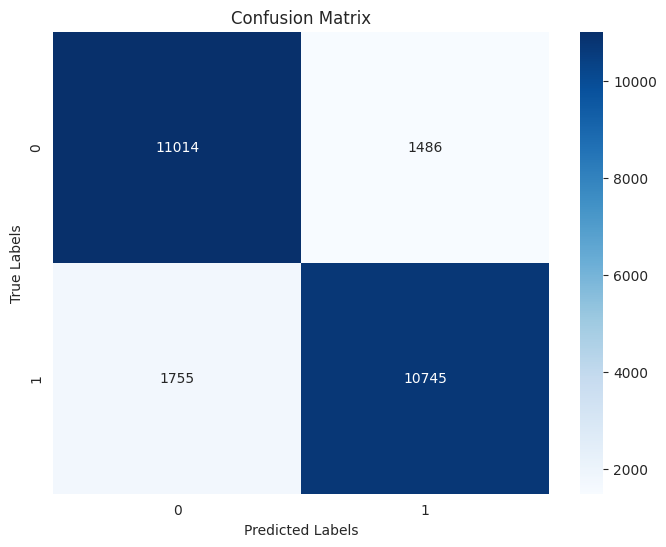

In [28]:
plot_confusion_matrix(cm=evaluation_results['tf-idf-test']["confusion-matrix"])

**Result** As we can see, results are significantly good in both train and set!!!

## b)Using Word2Vec

In [29]:
word2vec_model = Word2Vec(X_train, vector_size=200, window=20, min_count=1, workers=8, sg=0)

In [30]:
# Create Word Embeddings
X_train_word_embeddings = create_word_embeddings(X_train, word2vec_model.wv)
X_test_word_embeddings = create_word_embeddings(X_test, word2vec_model.wv)

In [31]:
start = time.time()

word2vec_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
word2vec_svm_clf.fit(X_train_word_embeddings, y_train)

end = time.time()
runtime['Word2Vec'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [32]:
y_pred = word2vec_svm_clf.predict(X_train_word_embeddings)
evaluation_results['word2vec-train'] = evaluation(y_train, y_pred)
print(evaluation_results['word2vec-train'])

{'Accuracy': 0.62572, 'Precision': 0.6226871730814271, 'Recall': 0.63808, 'F1-score': 0.6302896202931764, 'confusion-matrix': array([[7667, 4833],
       [4524, 7976]])}


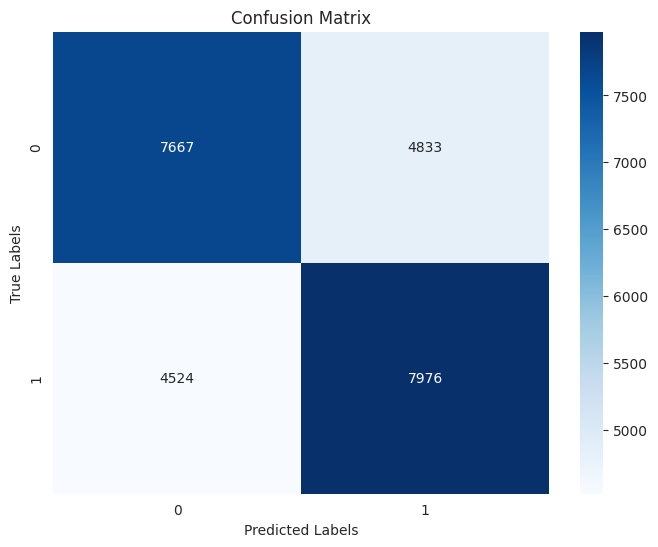

In [33]:
plot_confusion_matrix(cm=evaluation_results['word2vec-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [34]:
y_pred = word2vec_svm_clf.predict(X_test_word_embeddings)
evaluation_results['word2vec-test'] = evaluation(y_test, y_pred)
print(evaluation_results['word2vec-test'])

{'Accuracy': 0.6212, 'Precision': 0.6195549242424242, 'Recall': 0.62808, 'F1-score': 0.6237883362466232, 'confusion-matrix': array([[7679, 4821],
       [4649, 7851]])}


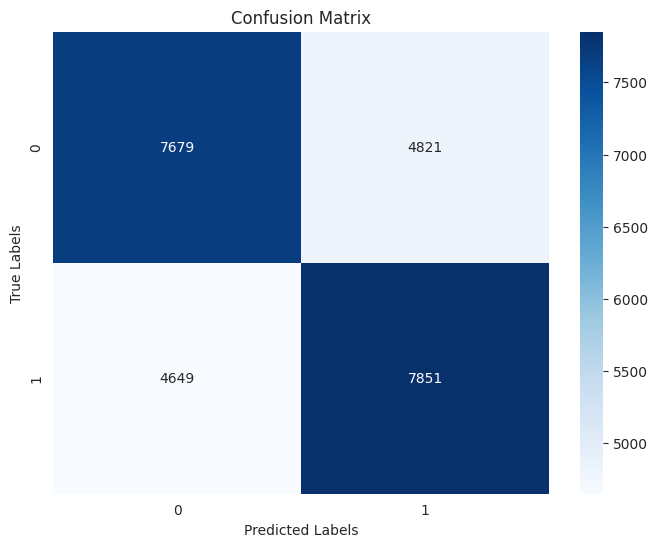

In [35]:
plot_confusion_matrix(cm=evaluation_results['word2vec-test']["confusion-matrix"])

# 5. Using all Word Embeddings(Optional)

### c) GloVe model

In [36]:
# glove_file = glove2word2vec('glove.6B.100d.txt', 'glove_word2vec_format.txt')
# glove_model = KeyedVectors.load_word2vec_format(glove_file)

In [37]:
# Create Word Embeddings
# X_train_word_embeddings = create_word_embeddings(X_train, glove_model.wv)
# X_test_word_embeddings = create_word_embeddings(X_test, glove_model.wv)

In [38]:
# start = time.time()

# glove_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
# glove_svm_clf.fit(X_train_word_embeddings, y_train)

# end = time.time()
# runtime['GloVe'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [39]:
# y_pred = glove_svm_clf.predict(X_train_word_embeddings)
# evaluation_results['glove-train'] = evaluation(y_train, y_pred)
# print(evaluation_results['glove-train'])

In [40]:
# plot_confusion_matrix(cm=evaluation_results['glove-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [41]:
# y_pred = glove_svm_clf.predict(X_test_word_embeddings)
# evaluation_results['glove-test'] = evaluation(y_test, y_pred)
# print(evaluation_results['glove-test'])

In [42]:
# plot_confusion_matrix(cm=evaluation_results['glove-test']["confusion-matrix"])

### d) FastText model

In [43]:
fasttext_model = FastText(X_train, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [44]:
# Create Word Embeddings
X_train_word_embeddings = create_word_embeddings(X_train, word2vec_model.wv)
X_test_word_embeddings = create_word_embeddings(X_test, word2vec_model.wv)

In [45]:
start = time.time()

fasttext_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
fasttext_svm_clf.fit(X_train_word_embeddings, y_train)

end = time.time()
runtime['Fasttext'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [46]:
y_pred = fasttext_svm_clf.predict(X_train_word_embeddings)
evaluation_results['fasttext-train'] = evaluation(y_train, y_pred)
print(evaluation_results['fasttext-train'])

{'Accuracy': 0.62572, 'Precision': 0.6226871730814271, 'Recall': 0.63808, 'F1-score': 0.6302896202931764, 'confusion-matrix': array([[7667, 4833],
       [4524, 7976]])}


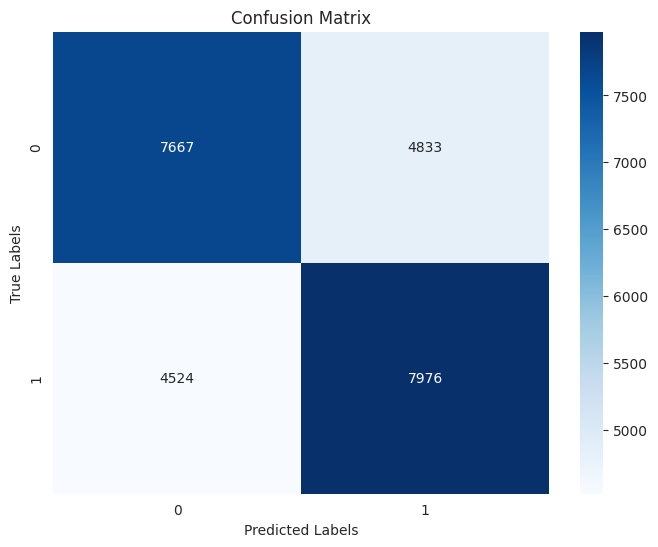

In [47]:
plot_confusion_matrix(cm=evaluation_results['fasttext-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [48]:
y_pred = fasttext_svm_clf.predict(X_test_word_embeddings)
evaluation_results['fasttext-test'] = evaluation(y_test, y_pred)
print(evaluation_results['fasttext-test'])

{'Accuracy': 0.6212, 'Precision': 0.6195549242424242, 'Recall': 0.62808, 'F1-score': 0.6237883362466232, 'confusion-matrix': array([[7679, 4821],
       [4649, 7851]])}


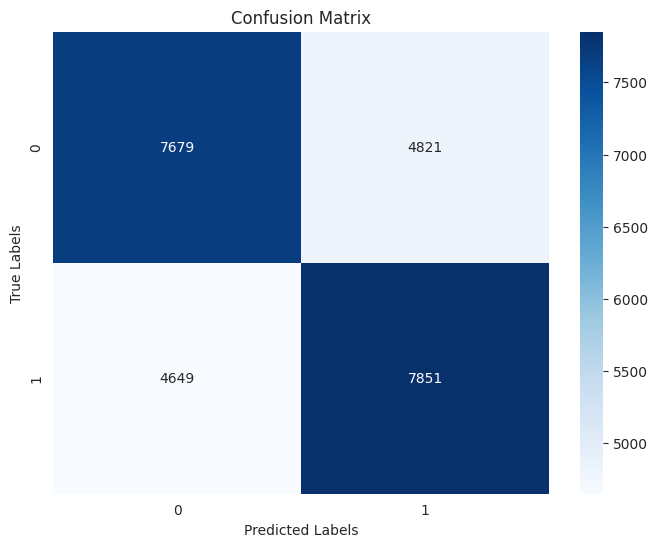

In [49]:
plot_confusion_matrix(cm=evaluation_results['fasttext-test']["confusion-matrix"])

# Apply LSA
Now we apply the LSA and see that with a number of component, we get the same accuracy but we have less runtime and memory for training

## a) Using tf-idf matrix:

In [50]:
X_train_lsa, X_test_lsa = apply_lsa(X_train_tfidf, X_test_tfidf, n_components=100)

In [51]:
start = time.time()

tfidf_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
tfidf_svm_clf.fit(X_train_lsa, y_train)

end = time.time()
runtime['tf-idf-LSA'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [52]:
y_pred = tfidf_svm_clf.predict(X_train_lsa)
evaluation_results['tf-idf-lsa-train'] = evaluation(y_train, y_pred)
print(evaluation_results['tf-idf-lsa-train'])

{'Accuracy': 0.85736, 'Precision': 0.8431929932390904, 'Recall': 0.878, 'F1-score': 0.8602445524376862, 'confusion-matrix': array([[10459,  2041],
       [ 1525, 10975]])}


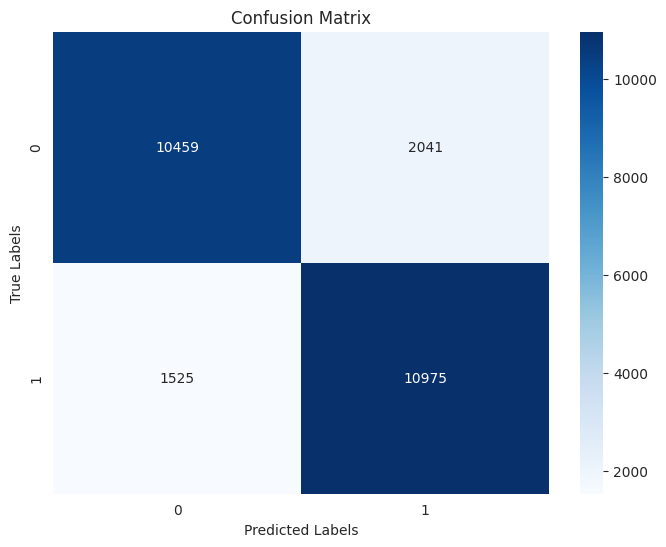

In [53]:
plot_confusion_matrix(cm=evaluation_results['tf-idf-lsa-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [54]:
y_pred = tfidf_svm_clf.predict(X_test_lsa)
evaluation_results['tf-idf-lsa-test'] = evaluation(y_test, y_pred)
print(evaluation_results['tf-idf-lsa-test'])

{'Accuracy': 0.855, 'Precision': 0.8458421011612501, 'Recall': 0.86824, 'F1-score': 0.8568947139868146, 'confusion-matrix': array([[10522,  1978],
       [ 1647, 10853]])}


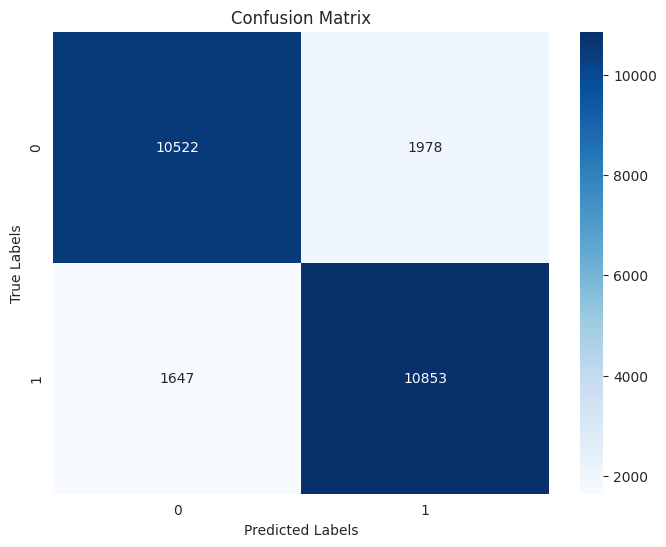

In [55]:
plot_confusion_matrix(cm=evaluation_results['tf-idf-lsa-test']["confusion-matrix"])

## b) Using Word2Vec:

In [56]:
# Create Word Embeddings
X_train_word_embeddings = create_word_embeddings(X_train, word2vec_model.wv)
X_test_word_embeddings = create_word_embeddings(X_test, word2vec_model.wv)

In [57]:
X_train_lsa, X_test_lsa = apply_lsa(X_train_word_embeddings, X_test_word_embeddings, n_components=50)

In [58]:
start = time.time()

word2vec_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
word2vec_svm_clf.fit(X_train_lsa, y_train)

end = time.time()
runtime['Word2Vec-LSA'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [59]:
y_pred = word2vec_svm_clf.predict(X_train_lsa)
evaluation_results['word2vec-lsa-train'] = evaluation(y_train, y_pred)
print(evaluation_results['word2vec-lsa-train'])

{'Accuracy': 0.62576, 'Precision': 0.6227549586131501, 'Recall': 0.638, 'F1-score': 0.6302853078321347, 'confusion-matrix': array([[7669, 4831],
       [4525, 7975]])}


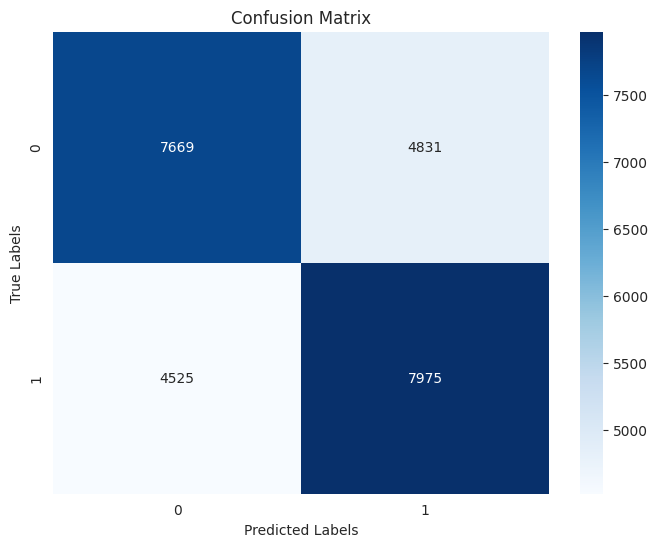

In [60]:
plot_confusion_matrix(cm=evaluation_results['word2vec-lsa-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [61]:
y_pred = word2vec_svm_clf.predict(X_test_lsa)
evaluation_results['word2vec-lsa-test'] = evaluation(y_test, y_pred)
print(evaluation_results['word2vec-lsa-test'])

{'Accuracy': 0.62108, 'Precision': 0.6194459790071818, 'Recall': 0.62792, 'F1-score': 0.6236542052361845, 'confusion-matrix': array([[7678, 4822],
       [4651, 7849]])}


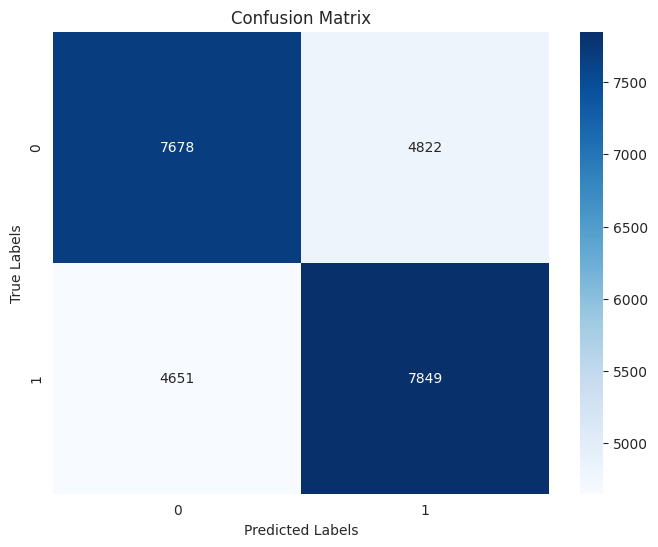

In [62]:
plot_confusion_matrix(cm=evaluation_results['word2vec-lsa-test']["confusion-matrix"])

## c) Using GloVe

In [63]:
# Create Word Embeddings
# X_train_word_embeddings = create_word_embeddings(X_train, glove_model.wv)
# X_test_word_embeddings = create_word_embeddings(X_test, glove_model.wv)

In [64]:
# X_train_lsa, X_test_lsa = apply_lsa(X_train_word_embeddings, X_test_word_embeddings, n_components=50)

In [65]:
# start = time.time()

# glove_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
# glove_svm_clf.fit(X_train_lsa, y_train)

# end = time.time()
# runtime['GloVe-LSA'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [66]:
# y_pred = glove_svm_clf.predict(X_train_lsa)
# evaluation_results['glove-lsa-train'] = evaluation(y_train, y_pred)
# print(evaluation_results['glove-lsa-train'])

In [67]:
# plot_confusion_matrix(cm=evaluation_results['glove-lsa-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [68]:
# y_pred = glove_svm_clf.predict(X_test_lsa)
# evaluation_results['glove-lsa-test'] = evaluation(y_test, y_pred)
# print(evaluation_results['glove-lsa-test'])

In [69]:
# plot_confusion_matrix(cm=evaluation_results['glove-lsa-test']["confusion-matrix"])

## d) Using Fasttext

In [112]:
# Create Word Embeddings
X_train_word_embeddings = create_word_embeddings(X_train, fasttext_model.wv)
X_test_word_embeddings = create_word_embeddings(X_test, fasttext_model.wv)

In [113]:
X_train_lsa, X_test_lsa = apply_lsa(X_train_word_embeddings, X_test_word_embeddings, n_components=100)

In [114]:
start = time.time()

fasttext_svm_clf = SVC(C=1, kernel='linear', gamma='auto')
fasttext_svm_clf.fit(X_train_lsa, y_train)

end = time.time()
runtime['Fasttext-LSA'] = end - start

### Evaluation
#### a) Evaluation on train set:

In [115]:
y_pred = fasttext_svm_clf.predict(X_train_lsa)
evaluation_results['fasttext-lsa-train'] = evaluation(y_train, y_pred)
print(evaluation_results['fasttext-lsa-train'])

{'Accuracy': 0.56896, 'Precision': 0.549483352468427, 'Recall': 0.76576, 'F1-score': 0.6398395721925134, 'confusion-matrix': array([[4652, 7848],
       [2928, 9572]])}


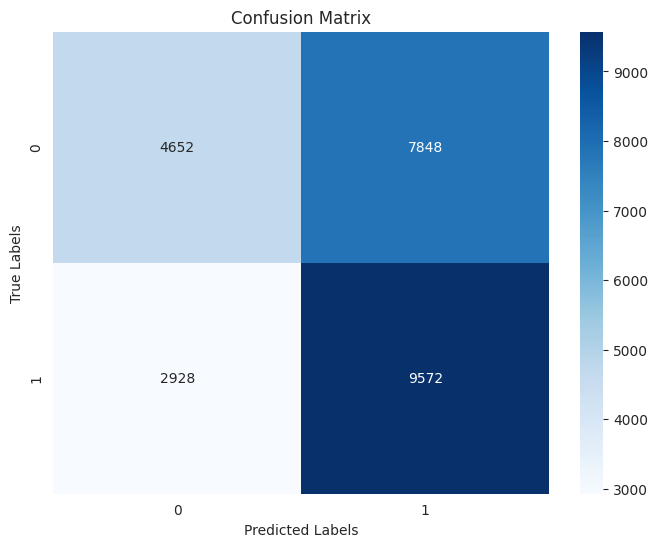

In [116]:
plot_confusion_matrix(cm=evaluation_results['fasttext-lsa-train']["confusion-matrix"])

#### b) Evaluation on test set:

In [117]:
y_pred = fasttext_svm_clf.predict(X_test_lsa)
evaluation_results['fasttext-lsa-test'] = evaluation(y_test, y_pred)
print(evaluation_results['fasttext-lsa-test'])

{'Accuracy': 0.56556, 'Precision': 0.5476813870948973, 'Recall': 0.75304, 'F1-score': 0.6341496277832047, 'confusion-matrix': array([[4726, 7774],
       [3087, 9413]])}


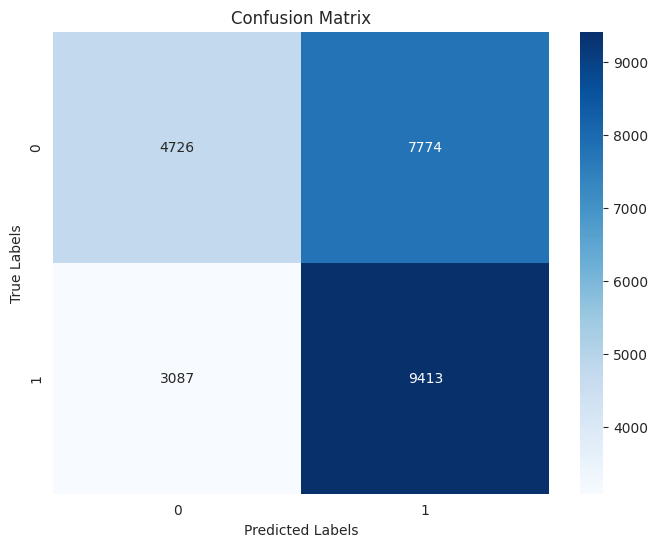

In [118]:
plot_confusion_matrix(cm=evaluation_results['fasttext-lsa-test']["confusion-matrix"])

In [119]:
runtime

{'tf-idf': 368.6298637390137,
 'Word2Vec': 87.33394002914429,
 'Fasttext': 90.84229516983032,
 'tf-idf-LSA': 25.55087423324585,
 'Word2Vec-LSA': 27.57274842262268,
 'Fasttext-LSA': 46.7807559967041}

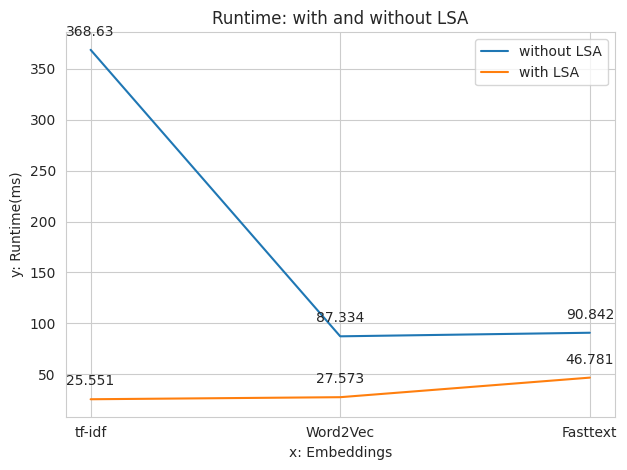

In [120]:
models = ['tf-idf', 'Word2Vec', 'Fasttext']
without_lsa = [runtime['tf-idf'], runtime['Word2Vec'], runtime['Fasttext']]
with_lsa = [runtime['tf-idf-LSA'], runtime['Word2Vec-LSA'], runtime['Fasttext-LSA']]
plt.plot(models, without_lsa, label='without LSA')
for i, txt in enumerate(without_lsa):
    plt.annotate(round(txt, 3), (i, without_lsa[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.plot(models, with_lsa, label='with LSA')
for i, txt in enumerate(with_lsa):
    plt.annotate(round(txt, 3), (i, with_lsa[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('x: Embeddings')
plt.ylabel('y: Runtime(ms)')
plt.title('Runtime: with and without LSA')
plt.legend()
plt.tight_layout()
plt.show()

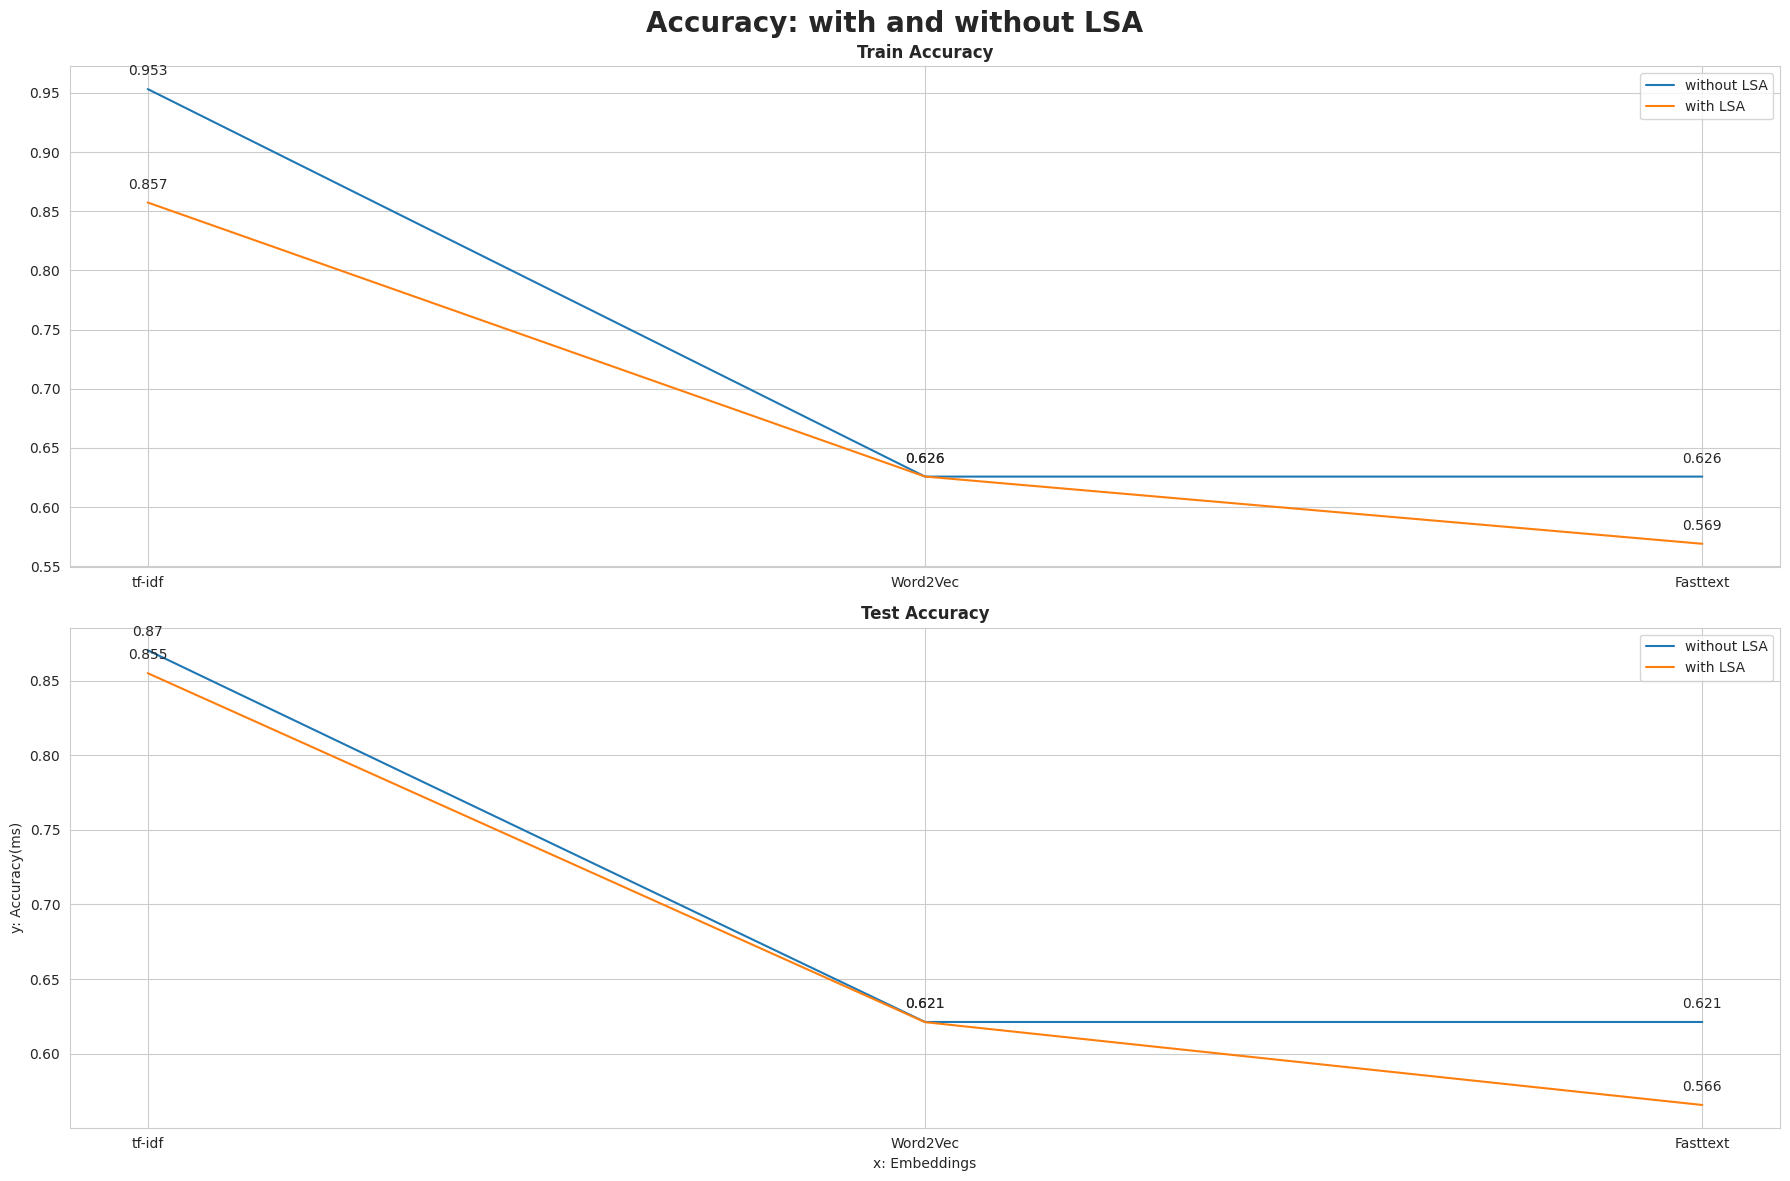

In [121]:
models = ['tf-idf', 'Word2Vec', 'Fasttext']
without_lsa = [evaluation_results['tf-idf-train']['Accuracy'], evaluation_results['word2vec-train']['Accuracy'], evaluation_results['fasttext-train']['Accuracy']]
with_lsa = [evaluation_results['tf-idf-lsa-train']['Accuracy'], evaluation_results['word2vec-lsa-train']['Accuracy'], evaluation_results['fasttext-lsa-train']['Accuracy']]

fig, axs = plt.subplots(2, 1, figsize=(18,12))

axs[0].plot(models, without_lsa, label='without LSA')
for i, txt in enumerate(without_lsa):
    axs[0].annotate(round(txt, 3), (i, without_lsa[i]), textcoords="offset points", xytext=(0,10), ha='center')

axs[0].plot(models, with_lsa, label='with LSA')
for i, txt in enumerate(with_lsa):
    axs[0].annotate(round(txt, 3), (i, with_lsa[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[0].set_title('Train Accuracy', fontweight='bold')
axs[0].legend()


without_lsa = [evaluation_results['tf-idf-test']['Accuracy'], evaluation_results['word2vec-test']['Accuracy'], evaluation_results['fasttext-test']['Accuracy']]
with_lsa = [evaluation_results['tf-idf-lsa-test']['Accuracy'], evaluation_results['word2vec-lsa-test']['Accuracy'], evaluation_results['fasttext-lsa-test']['Accuracy']]
axs[1].plot(models, without_lsa, label='without LSA')
for i, txt in enumerate(without_lsa):
    axs[1].annotate(round(txt, 3), (i, without_lsa[i]), textcoords="offset points", xytext=(0,10), ha='center')

axs[1].plot(models, with_lsa, label='with LSA')
for i, txt in enumerate(with_lsa):
    axs[1].annotate(round(txt, 3), (i, with_lsa[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[1].set_title('Test Accuracy', fontweight='bold')
axs[1].legend()

plt.xlabel('x: Embeddings')
plt.ylabel('y: Accuracy(ms)')
plt.suptitle('Accuracy: with and without LSA', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Report on Word Embeddings Performance Comparison
- a)Naive Baes model(Train set):
    - Accuracy: 89.75%
    - Precision: 91.84%
    - Recall: 87.24%
    - F1-score: 89.48%
- b)Naive Bayes Model (Test Set):
    - Accuracy: 81.84%
    - Precision: 85.82%
    - Recall: 76.30%
    - F1-score: 80.78%
- c) tf-idf model(train set)
    - Accuracy: 95.32%
    - Precision: 94.93%
    - Recall: 95.75%
    - F1-score: 95.34%
- d) tf-idf model(Test set)
    - Accuracy: 87.04%
    - Precision: 87.85%
    - Recall: 85.96%
    - F1-score: 86.84%
- Word2Vec Model:
    - Accuracy: 62.57%
    - Precision: 62.26%
    - Recall: 63.81%
    - F1-score: 63.03%
- GloVe Model:
    - Accuracy: 60.472%
    - Precision: 60.14%
    - Recall: 56.73%
    - F1-score: 56.93%
- FastText Model:
    - Accuracy: 62.57%
    - Precision: 62.26%
    - Recall: 63.80%
    - F1-score: 63.02%
### Analysis:

tf-idf with lsa Performance:
    - Achieved the highest accuracy among the three models (88%) after naive Bayes.
    - It shows the power of tf-idf with lsa model and its effectiveness
- Word2Vec Performance:
    - Achieved the third highest accuracy among the three models (64%).
    - Word2Vec is known for capturing semantic relationships effectively.
- GloVe Performance:
     - Demonstrated the lowest accuracy among the three models (60%).
    - Differences in training objectives and corpus characteristics may contribute to variations in performance.
- FastText Performance:
    - Achieved a slightly lower accuracy compared to Word2Vec (62%).
    - FastText is designed to handle subword information, which might be beneficial in specific contexts.
- Naive Bayes vs. Word Embeddings:
    - Naive Bayes exhibits strong performance on both train and test sets.
    - Word2Vec, GloVe, and FastText models show lower accuracy compared to Naive Bayes.
    - Word embeddings may struggle with this specific classification task.

- Word2Vec vs. GloVe vs. FastText:
    - Word2Vec achieves the highest accuracy among the word embedding models.
    - GloVe and FastText exhibit similar performance, with GloVe slightly outperforming FastText.
    - Differences in training objectives and corpus characteristics may contribute to variations in performance.
- Embedding-Specific Observations:
    - Word2Vec captures semantic relationships better in this context.
    - GloVe performs similarly to Word2Vec but with slightly lower accuracy.
    - FastText demonstrates lower precision but higher recall compared to Word2Vec and GloVe.
# Using LSA:
As we see in last two plots, applying LSA on models, reduce the runtime of training significantly but it doesn't affect the accuracy a lot.
### Key Observations:
- The choice of word embedding technique impacts the model's performance.
- Word2Vec outperformed both GloVe and FastText in terms of accuracy in this experiment.
- Differences in training objectives, corpus sizes, and subword information handling may contribute to variations in performance.
- Further analysis, such as examining precision, recall, and F1-score, may provide additional insights into the strengths and weaknesses of each embedding technique.
### Conclusion:
Naive Bayes demonstrates strong performance, suggesting its effectiveness for this classification task.
While Word2Vec demonstrated the highest accuracy in this experiment, it's essential to consider the specific characteristics of the dataset and the nature of the task at hand when choosing a word embedding technique.
Differences in performance highlight the impact of embedding techniques on the model's ability to capture semantic information.
Experimenting with different hyperparameters, model architectures, and training datasets may lead to further optimization and improved performance.
Evaluating embeddings on multiple metrics and conducting a detailed analysis helps in making informed decisions based on the specific requirements of the natural language processing task.